In [1]:
# load required libraries
options(stringsAsFactors = F)
options (repr.plot.width = 12, repr.plot.height = 6)
suppressPackageStartupMessages({
library(Seurat)
library(harmony)
library(ggplot2)
library(dplyr)
library(Matrix)
library(Hmisc)
library(ggsci)
library(viridis)
library(RColorBrewer)
library(ggrepel)
library(cowplot)
})
set.seed(123)

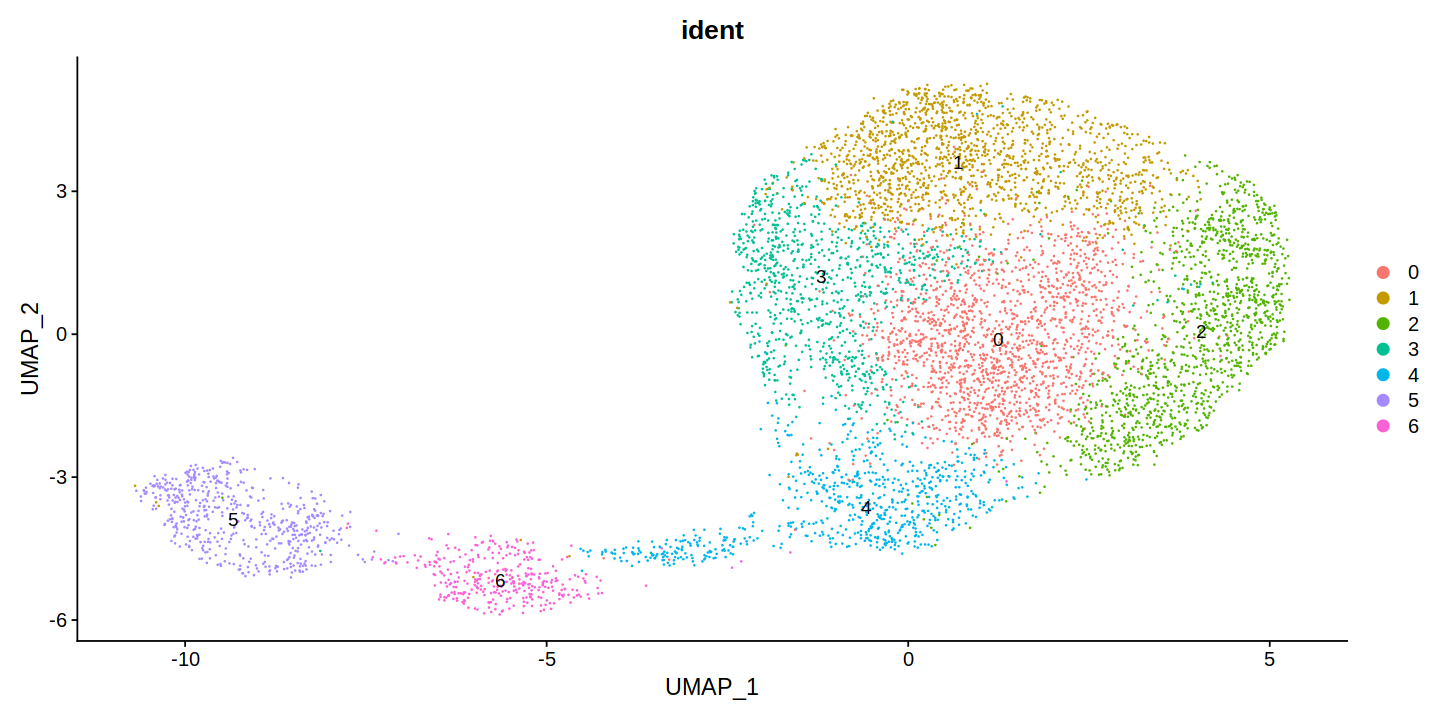

In [2]:
# load CTRL EC sample
sample.ref <- readRDS("./rds/sample_CTRL_EC_clean.rds")
DimPlot(sample.ref, label=TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1)

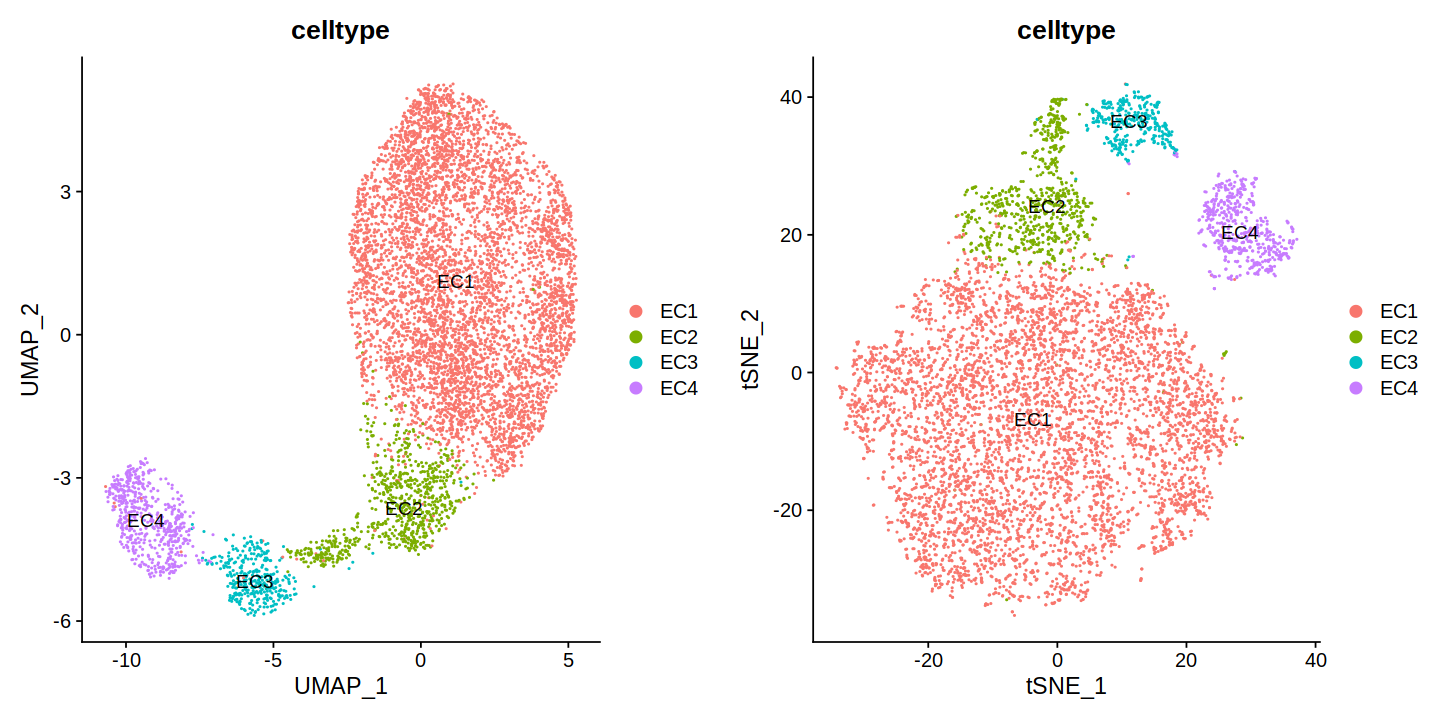

In [3]:
# subset assignment
cluster = c(0:6)
celltype = c("EC1","EC1","EC1","EC1","EC2","EC4","EC3")
sample.ref$celltype = plyr::mapvalues(x=Idents(sample.ref), from=cluster, to=celltype)
sample.ref$celltype <- as.character(sample.ref$celltype)
sample.ref$celltype <- factor(sample.ref$celltype, levels = sort(unique(celltype)))
a <- DimPlot(sample.ref, label = TRUE, reduction = "umap", group.by = "celltype")
b <- DimPlot(sample.ref, label = TRUE, reduction = "tsne", group.by = "celltype")
plot_grid(a, b, ncol = 2)

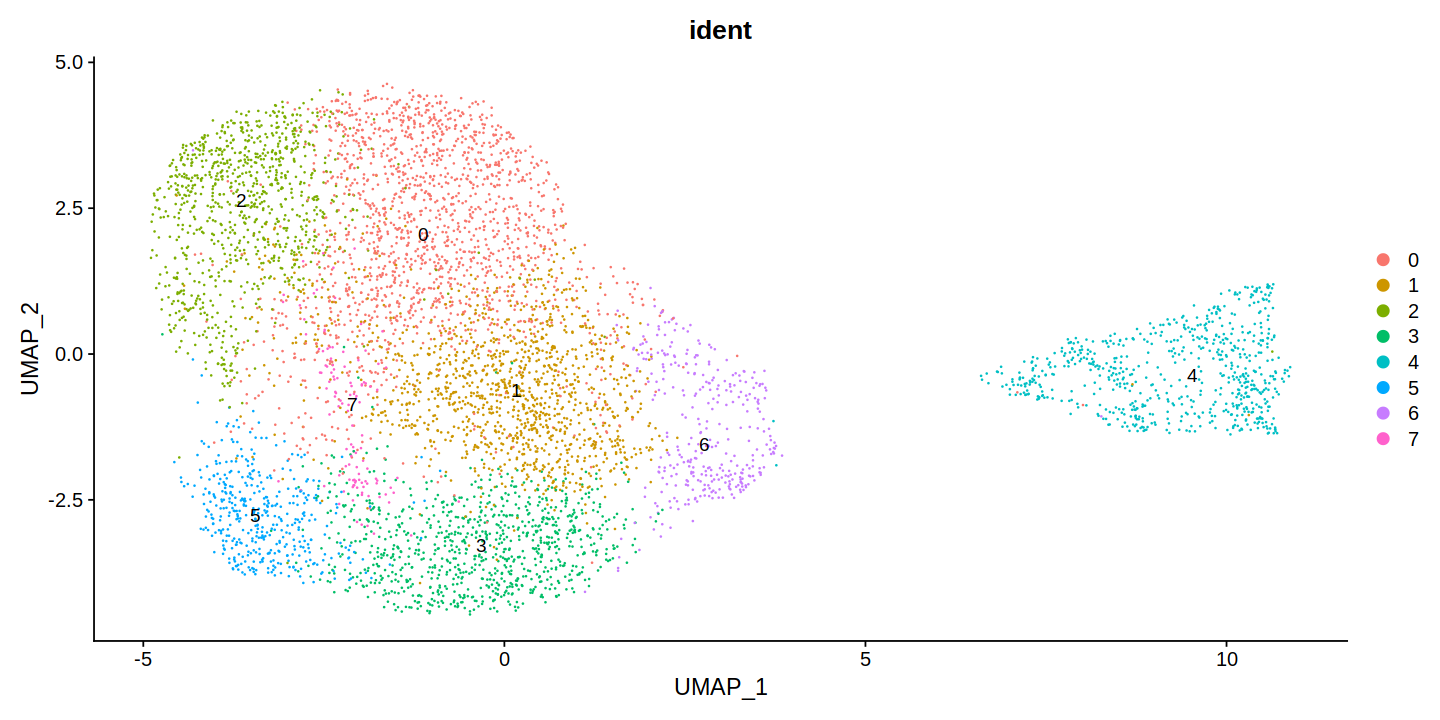

In [4]:
# load EXP EC sample
sample <- readRDS("./rds/sample_EXP_EC_clean.rds")
DimPlot(sample, label=TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1)

In [5]:
# find anchors
sc.anchors <- FindTransferAnchors(reference = sample.ref, query = sample, dims = 1:25, reference.reduction = "pca")
sc.query <- MapQuery(anchorset = sc.anchors, reference = sample.ref, query = sample, refdata = list(celltype = "celltype"), reference.reduction = "pca", reduction.model = "umap")

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 6414 anchors

Filtering anchors

	Retained 3867 anchors

Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours.”
Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Running UMAP projection

15:45:00 Read 6380 rows

15:45:00 Processing block 1 of 1

15:45:00 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:45:00 Initializing by weighted av

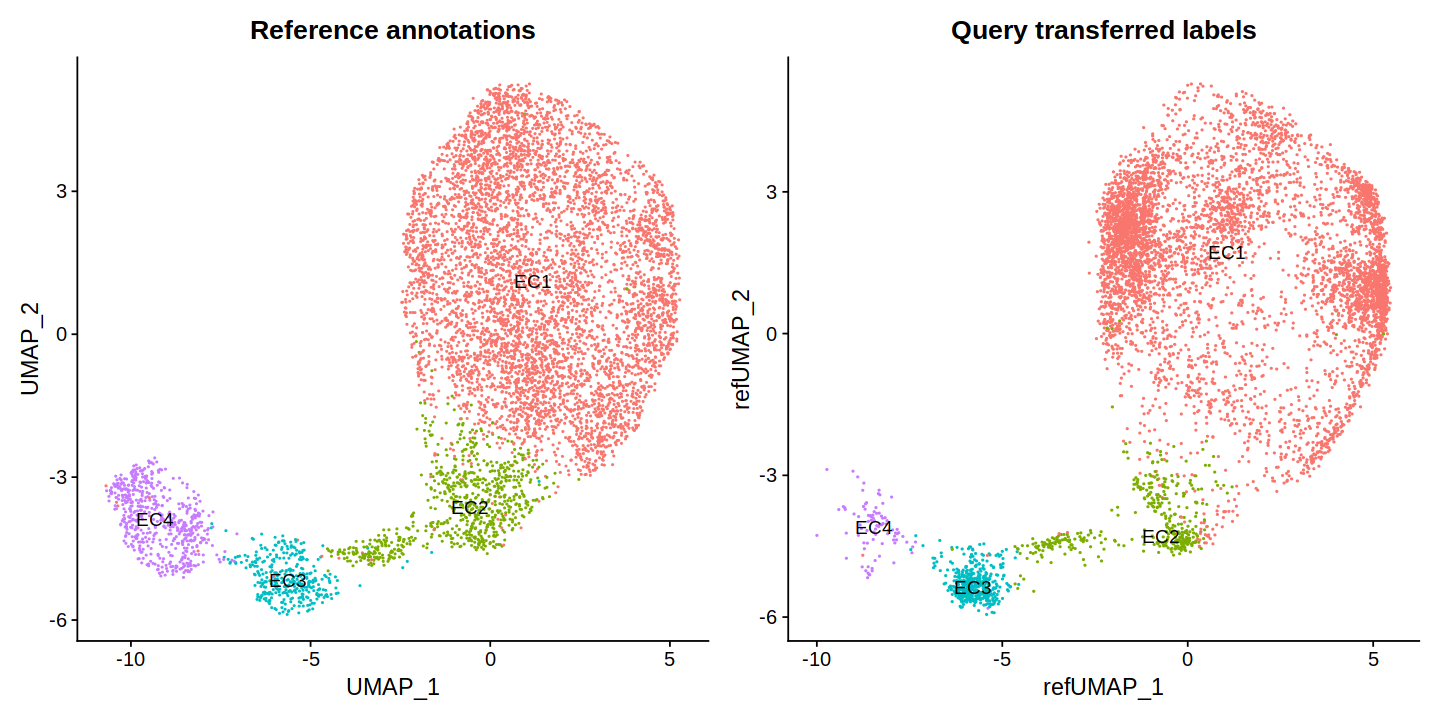

In [6]:
# project embedding
p1 <- DimPlot(sample.ref, reduction = "umap", label = TRUE, group.by = "celltype") + NoLegend() + ggtitle("Reference annotations")
p2 <- DimPlot(sc.query, reduction = "ref.umap", group.by = "predicted.celltype", label = TRUE) + NoLegend() + ggtitle("Query transferred labels")
p1 + p2

In [7]:
# find all markers
Idents(sample.ref) <- sample.ref$celltype
markers_all_CTRL <- FindAllMarkers(sample.ref, only.pos = T)
write.csv(markers_all_CTRL, "meta/markers_all_CTRL_EC.csv")

Idents(sc.query) <- sc.query$celltype
markers_all_EXP <- FindAllMarkers(sc.query, only.pos = T)
write.csv(markers_all_EXP, "meta/markers_all_EXP_EC.csv")

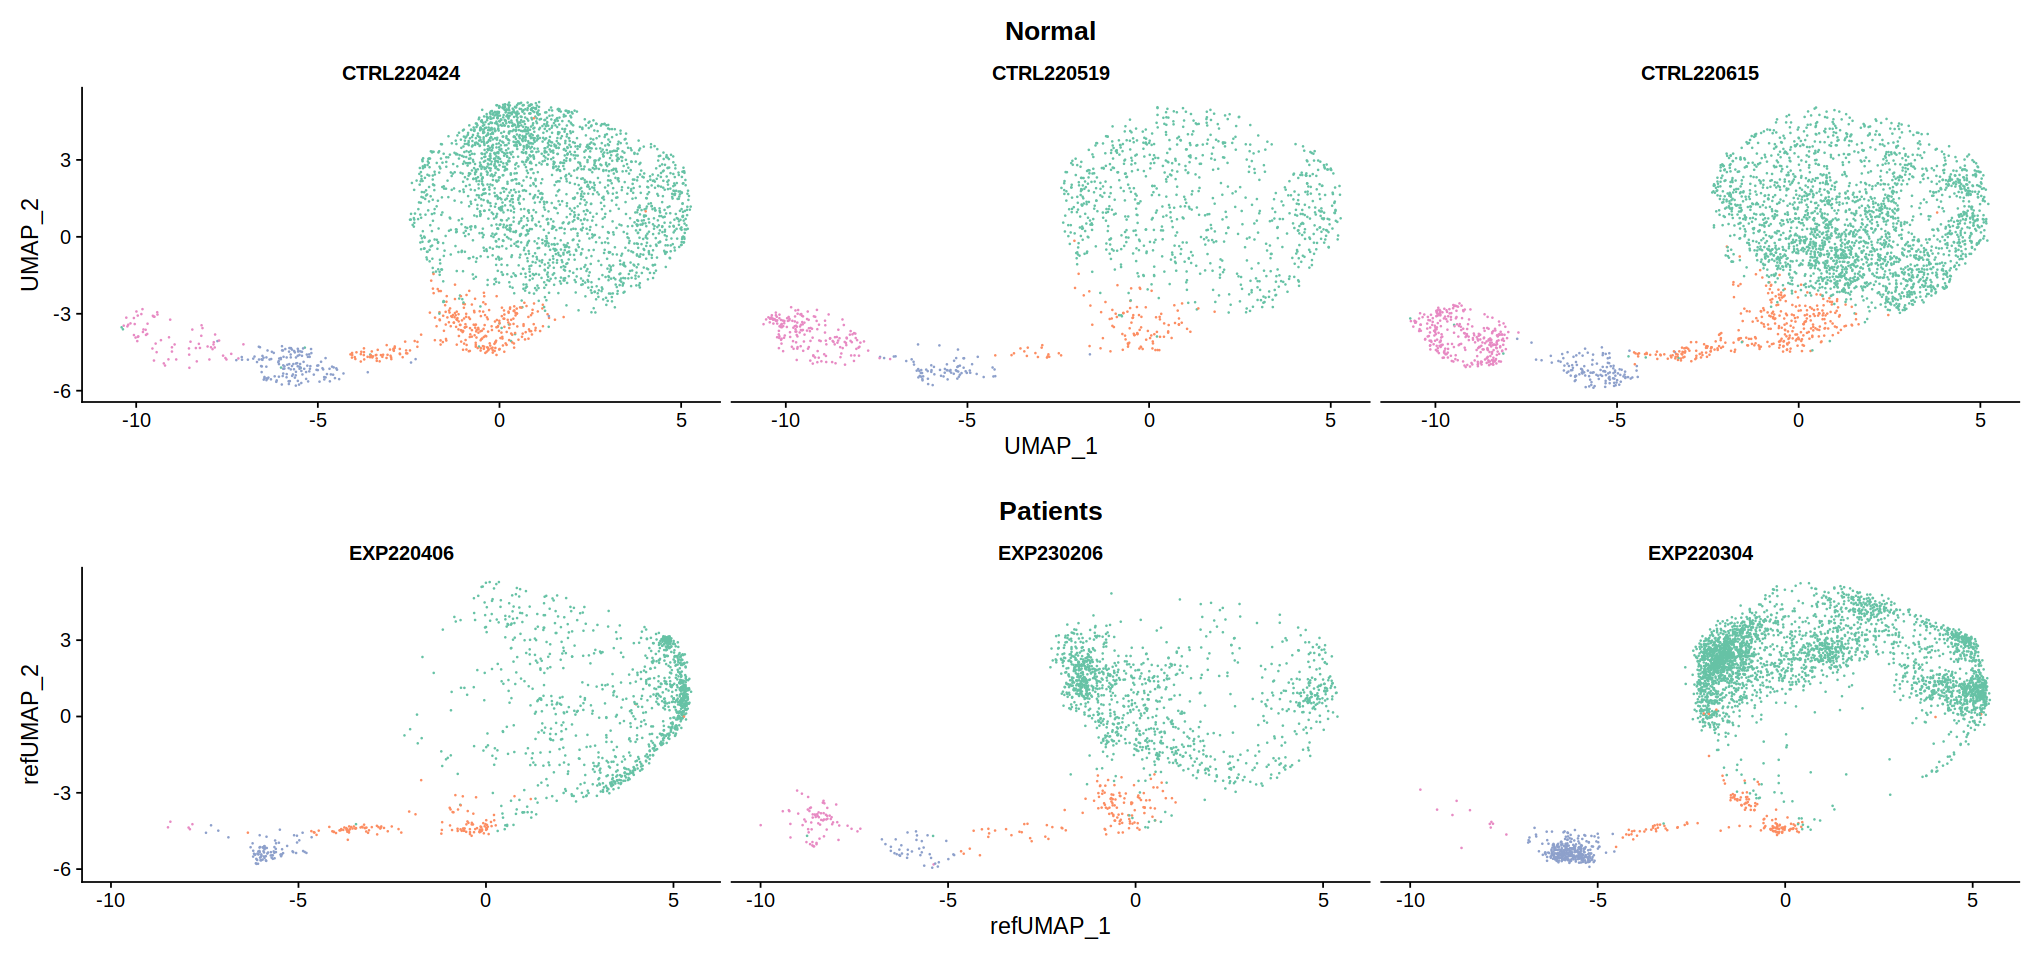

In [8]:
# sample distribution
options (repr.plot.width = 17, repr.plot.height = 8)
p1 <- DimPlot(sample.ref, reduction = "umap", label = F, group.by = "celltype", split.by = "orig.ident", pt.size = 0.1, cols = c('#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3')) + NoLegend() + ggtitle("Normal")
sc.query$orig.ident <- as.character(sc.query$orig.ident)
sc.query$orig.ident <- factor(sc.query$orig.ident, levels = c("EXP220406","EXP230206","EXP220304"))
p2 <- DimPlot(sc.query, reduction = "ref.umap", label = F, group.by = "predicted.celltype", split.by = "orig.ident", pt.size = 0.1, cols = c('#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3')) + NoLegend() + ggtitle("Patients")

plot_grid(p1, p2, ncol = 1)
ggsave("./figure/EC_subcluster_ref_map_split_by_patient.pdf", width = 9, height = 6.5)

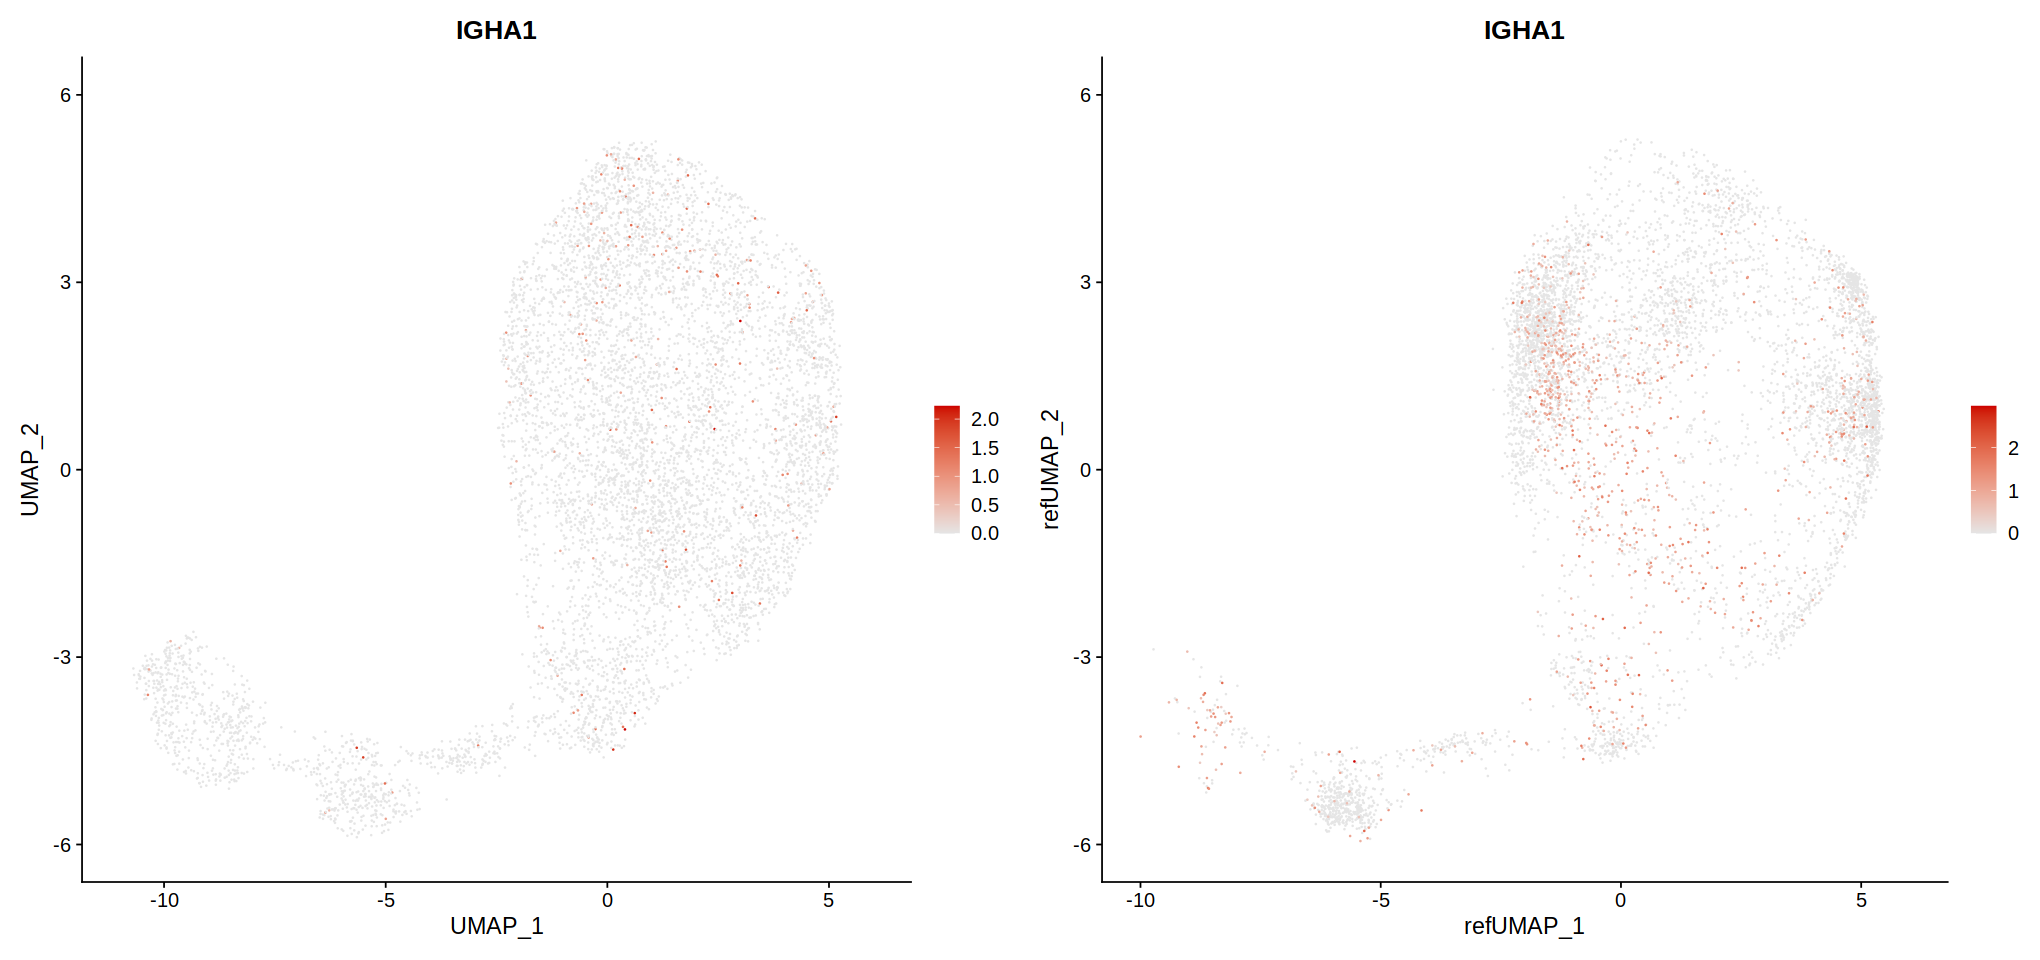

In [9]:
# plot marker gene
gene <- "IGHA1"
p1 <- FeaturePlot(sample.ref, label = F, features=gene, cols=c("grey90","red3"), reduction="umap", pt.size = 0.1, min.cutoff = 0, max.cutoff = 3)
p2 <- FeaturePlot(sc.query, label = F, features=gene, cols=c("grey90","red3"), reduction="ref.umap", pt.size = 0.1, min.cutoff = 0, max.cutoff = 3)
plot_grid(p1, p2, ncol = 2)

In [10]:
# save the data with celltype
saveRDS(sample.ref, file = "./rds/sample_CTRL_EC_celltype_ref.rds")
sc.query$celltype <- sc.query$predicted.celltype
saveRDS(sc.query, file = "./rds/sample_EXP_EC_celltype_mapping.rds")

In [11]:
# load the processed data
sample.ref <- readRDS("./rds/sample_CTRL_EC_celltype_ref.rds")
sc.query <- readRDS("./rds/sample_EXP_EC_celltype_mapping.rds")

In [12]:
# generate meta info for velocity analysis
sample <- sample.ref
sample$obs_name <- sample$orig.ident
sample$obs_name <- gsub(sample$obs_name, pattern = "CTRL220424", replacement = "XG20220424")
sample$obs_name <- gsub(sample$obs_name, pattern = "CTRL220519", replacement = "CAD0519")
sample$obs_name <- gsub(sample$obs_name, pattern = "CTRL220615", replacement = "CAD0615")

sample$obs_name <- paste(sample$obs_name, paste(unlist(strsplit(rownames(sample@meta.data), split = "-"))[seq(1, 2*nrow(sample@meta.data), by = 2)], "x", sep = ""), sep = ":")

write.csv(sample$obs_name, file = "meta/CTRL/cellID_obs.csv", row.names = FALSE)

cell_embeddings <- Embeddings(sample, reduction = "umap")
rownames(cell_embeddings) <- sample$obs_name
write.csv(cell_embeddings, file = "meta/CTRL/cell_embeddings.csv")

write.csv(data.frame(x = sample@meta.data$celltype, row.names = sample$obs_name), file = "meta/CTRL/clusters.csv")

In [13]:
# generate meta info for velocity analysis
sample <- sc.query
sample$obs_name <- sample$orig.ident
sample$obs_name <- gsub(sample$obs_name, pattern = "EXP220304", replacement = "CAD0304")
sample$obs_name <- gsub(sample$obs_name, pattern = "EXP220406", replacement = "CAD0406XG")
sample$obs_name <- gsub(sample$obs_name, pattern = "EXP230206", replacement = "CADD112")

sample$obs_name <- paste(sample$obs_name, paste(unlist(strsplit(rownames(sample@meta.data), split = "-"))[seq(1, 2*nrow(sample@meta.data), by = 2)], "x", sep = ""), sep = ":")

write.csv(sample$obs_name, file = "meta/EXP/cellID_obs.csv", row.names = FALSE)

cell_embeddings <- Embeddings(sample, reduction = "ref.umap")
rownames(cell_embeddings) <- sample$obs_name
write.csv(cell_embeddings, file = "meta/EXP/cell_embeddings.csv")

write.csv(data.frame(x = sample@meta.data$celltype, row.names = sample$obs_name), file = "meta/EXP/clusters.csv")

In [14]:
# plot marker genes of EC7
markers <- read.csv("meta/markers_EC7_onlyPos_significant.csv", row.names = 1)
markers <- rownames(markers)
markers <- unique(c("PECAM1","VWF","CDH5", # EC
"ACKR1","POSTN","NRP2", # VEC
"BTNL9","CA4","CD300LG", # CEC
"SOX17","HEY2","GJA5" # AEC
))
markers <- c('SPP1','IGHA1','CCL3L1','IGHG4','IL1B','IGKC','PLA2G2A','IGLC3','CDH13','IGHG1','IGHG3','IGLC2','STEAP1','RPS26','HLA-DRB5','CCL4','PVT1','PCDH17','MT-ND3','TCIM','IGHG2','CFAP54','CXCL8','COL3A1','MT2A','FOSB','AAK1','BTG2','SOCS3','CPE','NR4A1','KLF2','DUSP1','CALCRL','AC020916.1','CSRNP1','MT-CO1','OGN','BMPER','ACTA2','EGR1','NRP1','ZFP36','CDKN1A','RPS29','ATF3','FAM198B','RAMP3','RPS27','MT-CO2','MT-ND1','RAMP2','MT-CYB','BGN','MT-ND5','LEPR','ERAP2','TMTC1','FOSL1','PLPP1','FRMD4B','IL6','CXCL2','SOX5','LMNA','FOS','LMCD1','ITPKC','AC022217.3','JUNB','ITGA10','MT-ND4','PI15','AC105402.3','ADAMTS1','PER1','MYC','MT1M','PPIC','IFITM1','CSGALNACT1','INMT','EPB41L3','MT-CO3','TIMP1','TAGLN','GALNT15','ARHGAP26','TACC1','RPL36A','HMCN1','YBX3','IL4R','RUNX1T1','ITM2A','PDGFC','PLK3','ABLIM3','DYNLL1','RYR3','STEAP1B','RPS28','CHSY1','THRB','VCAM1','ITLN1','NEAT1','NEDD9','IMMP2L','GFOD1','ELL2','LIMCH1','FCGRT','COL1A2','AHR','SPOCK1','SNCAIP','MTRNR2L12','HMGCLL1','IER2','IFITM3','LMO2','NET1','NUCB2','SWAP70','MT1X','SVEP1','ADAMTS9-AS2','WNT2B','CCDC85A','ABCC4','GPRC5A','KLF4','MIF','PPM1D','NDUFA3','XAF1','RPL37A','ARL15','CSMD1','DUSP6','TFPI','MT-ND2','FOXP1','MCU','KLF6','ATP1B3','EPAS1','MCL1','RPL37','PPA1','FAM107A','MTRNR2L8','COX7C','CRTAC1','NKAIN2','SLC7A2','ADAMTSL3','STOM','IGFBP2','RPL41','PDE4B','CEBPB','GCNT2','THSD7A','SEPT7','AC016831.7','RNASE1')
for(gene in markers){
    p1 <- FeaturePlot(sample.ref, label = F, features=gene, cols=c("grey90","red3"), reduction="umap", pt.size = 0.1, min.cutoff = 0)
    p2 <- FeaturePlot(sc.query, label = F, features=gene, cols=c("grey90","red3"), reduction="ref.umap", pt.size = 0.1, min.cutoff = 0)
    plot_grid(p1, p2, ncol = 2)
    ggsave(paste0("./markers/umap/", gene, ".pdf"), width = 13, height = 5)
}

In [15]:
# list the session info
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/zju/ty/miniconda/envs/singlecell/lib/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1      ggrepel_0.9.4      RColorBrewer_1.1-3 viridis_0.6.4     
 [5] viridisLite_0.4.2  ggsci_3.0.0        Hmisc_5.1-1        Matrix_1.6-1.1    
 [9] dplyr_1.1.4        ggplot2_3.5.1      harmony_0.1.1     